### Imports

In [2]:
### PYMOO
from pymoo.core.problem import Problem, ElementwiseProblem, StarmapParallelization
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.util.display.multi import MultiObjectiveOutput
from pymoo.core.sampling import Sampling
from pymoo.core.mutation import Mutation
from pymoo.indicators.hv import HV
from pymoo.termination.max_gen import MaximumGenerationTermination
from pymoo.termination import get_termination
from pymoo.core.crossover import Crossover
from pymoo.util.misc import crossover_mask

#multiprocessamento e outros
from tqdm.notebook import trange, tqdm
import multiprocessing, sys, time, itertools, dill, random, os, pickle, copy

#Pandas, SKLearn e etc.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

from skrebate import ReliefF
from ucimlrepo import fetch_ucirepo
from sklearn.datasets import fetch_openml

In [3]:
from feature_selection_tools import *

In [4]:
from sklearn.datasets import make_classification
X, y = make_classification(random_state=42, n_samples = 50, n_features = 100, n_informative = 10, n_redundant=10, n_repeated=10)

pool_values = generate_importances(X, y)
len(pool_values)

8

In [7]:
X, y = make_classification(random_state=42, n_samples = 100, n_features = 100, n_informative = 10, n_redundant=10, n_repeated=10)

sns.set_style('ticks')
pool = multiprocessing.Pool(n_process, initializer=_init_evaluator(np.zeros((100,100)),np.zeros(100)))
runner = StarmapParallelization(pool.starmap)
problem = GeneSelection(X = X, y = y, runner=runner)

classifier = DecisionTreeClassifier()

individuals = FeatureSampling(feature_dfs = pool_values).do(problem, n_samples = 100)

NameError: name 'make_classification' is not defined

### Restrictions

In [5]:
MIN_FEATURES = 1
MAX_FEATURES = 100

model = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(max_depth=8))
CLASSIFIER = model

### Sampling, Mutation and Crossover Functions

In [6]:
### Sampling
class BinaryRandomSampling(Sampling):
    def __init__(self, **kwargs):
        self.max_features = kwargs.pop('max_features', 100)
        super().__init__(**kwargs)
    def _do(self, problem, n_samples, **kwargs):
        val = np.random.random((n_samples, problem.n_var))
        val = checkEmpty(np.array((val < 0.5).astype(bool)), 100)
        return val
        
class BinaryDistributedWeightsSampling(Sampling):
    def __init__(self, **kwargs):
        self.sampling_weights = kwargs.pop('sampling_weights', None)
        self.seed = kwargs.pop('seed', 42)
        self.max_features = kwargs.pop('max_features', 100)
        super().__init__(**kwargs)
        
    def _do(self, problem, n_samples, **kwargs):
        random.seed(self.seed)
        try:
            self.sampling_weigh = self.sampling_weights / np.sum(self.sampling_weights, dtype=float)
        except:
            pass
        population = []
        for i in range(n_samples):
            trues = np.random.randint(1, min(self.max_features, problem.n_var) + 1)
            individual = np.full(problem.n_var, False)
            individual[np.random.choice(problem.n_var, trues, p = self.sampling_weights, replace = False )] = True
            population.append(individual)
        population = np.array(population)
        return population


class BinaryPoolSampling(Sampling):
    def __init__(self, **kwargs):
        self.sampling_weights = kwargs.pop('sampling_weights', None)
        self.seed = kwargs.pop('seed', 42)
        self.max_features = kwargs.pop('max_features', 100)
        self.pool = kwargs.pop('pool', None)
        super().__init__(**kwargs)
        
    def _do(self, problem, n_samples, **kwargs):
        random.seed(self.seed)
        population = []
        pool_values = []
        for value in self.pool:
            value = (value + 0.00001)  / np.sum((value + 0.00001), dtype=float)
            pool_values.append(value)
        print(n_samples, len(self.pool))
        repeat_times, remainder = divmod(n_samples, len(self.pool))
        pool_values = pool_values * repeat_times + pool_values[:remainder]
        for i,value in zip(range(n_samples),pool_values):
            trues = np.random.randint(1, min(self.max_features, problem.n_var) + 1)
            individual = np.full(problem.n_var, False)
            individual[np.random.choice(problem.n_var, trues, p = value, replace = False)] = True
            population.append(individual)
        population = np.array(population)
        print(len(population))
        return population

class PoolMutation(Mutation):
    def __init__(self, **kwargs):
        self.pool = kwargs.pop('pool', None)
        self.max_features = kwargs.pop('max_features', 100)
        super().__init__(**kwargs)
        
    def _do(self, problem, X, **kwargs):
        # Itera diretamente em X e full para alterar os valores
        for individual in X:
            true_indices = np.where(individual)[0]
            false_indices = np.where(~individual)[0]
        
            # Seleciona um índice de variáveis não nulas
            if len(true_indices) >= 1:
                m = np.random.choice(true_indices, size=1, replace=False)
                individual[m] = 0
            index = np.random.choice(len(self.pool))
            value = self.pool[index]
            value = value[false_indices]
            # Obtém os índices ordenados do maior para o menor peso
            sorted_indices = np.argsort(value)[::-1]
            # Seleciona os top N índices
            sorted_indices[:min(MAX_FEATURES, len(true_indices))]
            # Seleciona um índice de variáveil nula
            if len(false_indices) >= 1:
                m = np.random.choice(sorted_indices, size=1, replace=False)
                # Aplica a lógica baseada no Score
                individual[m] = 1

        for individual in X:
            if individual.sum() == 0:
                individual[np.random.choice(range(len(individual)))] = True
            while individual.sum() > MAX_FEATURES:
                individual = individual[np.random.choice(np.where(individual == True)[0], MAX_FEATURES)]
        X = checkEmpty(X, self.max_features)
        return X


class SparseEASampling(Sampling):
    def __init__(self, **kwargs):
        self.sc = kwargs.pop('sc', None)
        self.seed = kwargs.pop('seed', 42)
        self.max_features = kwargs.pop('max_features', 100)
        super().__init__(**kwargs)
        
    def _do(self, problem, n_samples, **kwargs):
        random.seed(self.seed)
        population = []
        for i in range(n_samples):
            trues = np.random.randint(1, min(self.max_features, problem.n_var)  + 1)
            individual = np.full(len(self.sc), False)
            
            for j in range(trues):
                candidates = random.choices(range(len(self.sc)), k = 2)
                if self.sc[candidates[0]] > self.sc[candidates[1]]:
                    individual[candidates[0]] = True
                else:
                    individual[candidates[1]] = True

            population.append(individual)
        population = np.array(population)
        row_sums = population.sum(axis=1)
        # Mostra a matriz ordenada
        return population

class ReliefFSampling(Sampling):
    def __init__(self, **kwargs):
        self.sc = kwargs.pop('sc', None)
        self.seed = kwargs.pop('seed', 42)
        self.max_features = kwargs.pop('max_features', 100)
        super().__init__(**kwargs)
        
    def tournament_selection(self, num, sc):
        selected_indices = []
        for _ in range(num):
            # Escolhe dois índices aleatórios
            idx1, idx2 = np.random.choice(len(sc), size=2, replace=False)
            # Compara as pontuações e seleciona o índice com a maior pontuação
            if sc[idx1] > sc[idx2]:
                selected_indices.append(idx1)
            else:
                selected_indices.append(idx2)
        # Remove duplicatas e retorna os índices únicos
        return list(set(selected_indices))

    def _do(self, problem, n_samples, **kwargs):
        population = np.full((n_samples, len(self.sc)), False)  # Inicializa a população com zeros
        for i in range(n_samples):
            num = np.random.randint(1, min(self.max_features, problem.n_var)  + 1)
            selected_indices = self.tournament_selection(num, self.sc)
            population[i, selected_indices] = True
        return population

### Mutation
def checkEmpty(population, max_features):
    max_restriction = True
    new_pop = []
    for individual in population:
        if individual.sum() == 0:
            individual[np.random.randint(0,(len(individual)))] = True
        if individual.sum() > max_features:
            true_indices = np.array(list(range(len(individual))))[individual]
            individual = np.full(len(individual), False)
            individual[random.choices(true_indices, k = max_features)] = True
        new_pop.append(individual)
    return np.array(new_pop)

class BitflipMutationLimitedBalanced(Mutation):
    def __init__(self, **kwargs):
        self.weights = kwargs.pop('weights', None)
        self.max_features = kwargs.pop('max_features', 100)
        super().__init__(**kwargs)
        
    def _do(self, problem, X, **kwargs):
        prob_var = self.get_prob_var(problem, size=(len(X), 1))
        full = np.random.rand(*X.shape) < prob_var  # Evita uma criação redundante de matriz e faz o flip diretamente

        # Itera diretamente em X e full para alterar os valores
        for individual, vector in zip(X, full):
            num_changes = min(self.max_features, np.sum(vector))  # Limita a quantidade de alterações pelo MAX_FEATURES
            true_indices = np.where(individual)[0]
            false_indices = np.where(~individual)[0]
        
            # Seleciona índices aleatórios para trocar, dividindo o número de mudanças igualmente entre 'True' e 'False'
            flip_choices = np.random.rand(num_changes) < 0.5
            true_flips = np.sum(flip_choices)
            false_flips = num_changes - true_flips

            if self.weights is not None:
                weights = self.weights[false_indices]
            else:
                weights = None
                
            if true_flips > 0 and len(true_indices) > 0:
                individual[np.random.choice(true_indices, min(true_flips, len(true_indices)), replace=False)] = False
            if false_flips > 0 and len(false_indices) > 0:
                individual[random.choices(false_indices, k = min(false_flips, len(false_indices)), weights=weights)] = True
        X = checkEmpty(X, self.max_features)
        return X


class SparseEAMutation(Mutation):
    def __init__(self, **kwargs):
        self.weights = kwargs.pop('weights', None)
        self.max_features = kwargs.pop('max_features', 100)
        super().__init__(**kwargs)
        
    def _do(self, problem, X, **kwargs):
        # Itera diretamente em X e full para alterar os valores
        for individual in X:
            true_indices = np.where(individual)[0]
            false_indices = np.where(~individual)[0]
        
            if np.random.rand() < 0.5:
                # Seleciona dois índices de variáveis não nulas
                if len(true_indices) >= 2:
                    m, n = np.random.choice(true_indices, size=2, replace=False)
                    # Aplica a lógica baseada no Score
                    if self.weights[m] < self.weights[n]:
                        individual[m] = 0
                    else:
                        individual[n] = 0
            else:
                # Seleciona dois índices de variáveis nulas
                if len(false_indices) >= 2:
                    m, n = np.random.choice(false_indices, size=2, replace=False)
                    # Aplica a lógica baseada no Score
                    if self.weights[m] > self.weights[n]:
                        individual[m] = 1
                    else:
                        individual[n] = 1

        for individual in X:
            if individual.sum() == 0:
                individual[np.random.choice(range(len(individual)))] = True
            while individual.sum() > MAX_FEATURES:
                individual = individual[np.random.choice(np.where(individual == True)[0], MAX_FEATURES)]
        X = checkEmpty(X, self.max_features)
        return X

class ReliefFMutation(Mutation):
    def __init__(self, **kwargs):
        self.sc = kwargs.pop('sc', None)
        self.max_features = kwargs.pop('max_features', 100)
        super().__init__(**kwargs) # Scores das features do ReliefF

    def _do(self, problem, X, **kwargs):
        X_ = []
        for individual in X:
            selected_indices = np.where(individual == True)[0]
            unselected_indices = np.where(individual == False)[0]
            
            # 1. Decidir se remove ou adiciona uma feature
            if np.random.rand() < 0.5:
                # Mutação Tipo 1: Remover uma feature selecionada (menor score)
                if len(selected_indices) > 1:
                    # Torneio binário invertido (prioriza features com scores BAIXOS)
                    scores = -self.sc[np.array(selected_indices)]  # Inverte os scores
                    winner = self._binary_tournament(selected_indices, scores)
                    individual[winner] = False  # Remove a feature
            elif len(selected_indices) < MAX_FEATURES:
                # Mutação Tipo 2: Adicionar uma feature não selecionada (maior score)
                unselected_indices = np.where(individual == False)[0]
                if len(unselected_indices) > 0:
                    # Torneio binário normal (prioriza features com scores ALTOS)
                    scores = self.sc[unselected_indices]
                    winner = self._binary_tournament(unselected_indices, scores)
                    individual[winner] = True  # Adiciona a feature
            
            X_.append(individual)
        X_ = checkEmpty(X_, self.max_features)
        return np.array(X_)

    def _binary_tournament(self, candidates, scores):
        # Escolhe 2 candidatos aleatoriamente e seleciona o com maior score
        idx = np.random.choice(len(candidates), 2, replace= True if len(candidates) == 1 else False) #Quanto tem só 1 individuo, o replace precisa ser True
        winner = candidates[idx[np.argmax(scores[idx])]]
        return winner

### Crossover
class SparseEACrossover(Crossover):

    def __init__(self, **kwargs):
        self.sc = kwargs.pop('sc', None)
        super().__init__(2, 2, **kwargs)

    def _do(self, _, X, **kwargs):
        _, n_matings, n_var = X.shape
        M = np.random.random((n_matings, n_var)) < 0.5
        X_ = list(np.copy(X[0]))
        X_.extend(list(np.copy(X[1])))
        X_.extend(X_)
        O = []
        while X_:
            # Seleciona dois pais aleatoriamente
            p_idx, q_idx = np.random.choice(len(X_), size=2, replace=False)
            p = X_.pop(max(p_idx, q_idx)) # Remove o maior primeiro
            q = X_.pop(min(p_idx, q_idx))
            # Remove os pais de P_prime
            #print('len X_', len(X_))
            o_mask = p.copy()
            # Determina se será usada a primeira ou segunda lógica
            if np.random.rand() < 0.5:
                # Seleciona duas variáveis de decisão aleatórias de p.mask ∩ q.mask
                common_indices = np.where(p & ~q)[0]
                if len(common_indices) < 2:
                    O.append(np.array(o_mask))
                    continue  # Se não houver pelo menos dois elementos em comum, pula esta iteração
                m, n = np.random.choice(common_indices, size=2, replace=False)
                # Aplica a regra com base nas pontuações
                if self.sc[m] < self.sc[n]:
                    o_mask[m] = False
                else:
                    o_mask[n] = False
            else:
                # Seleciona duas variáveis de decisão aleatórias de p.mask ∩ q.mask
                common_indices = np.where(~p & q)[0]
                if len(common_indices) < 2:
                    O.append(np.array(o_mask))
                    continue  # Se não houver pelo menos dois elementos em comum, pula esta iteração
                
                m, n = np.random.choice(common_indices, size=2, replace=False)
    
                # Aplica a regra com base nas pontuações
                if self.sc[m] > self.sc[n]:
                    o_mask[m] = True
                else:
                    o_mask[n] = True
            # Adiciona o descendente à lista de descendentes
            O.append(np.array(o_mask))
        O = np.array(O)
        return O.reshape(2,int(O.shape[0]/2), O.shape[1])

class UniformCrossover(Crossover):

    def __init__(self, **kwargs):
        super().__init__(2, 2, **kwargs)

    def _do(self, _, X, **kwargs):
        _, n_matings, n_var = X.shape
        M = np.random.random((n_matings, n_var)) < 0.5
        _X = crossover_mask(X, M)
        return _X
        
class BinaryCrossover(Crossover):
    def __init__(self, **kwargs):
        self.max_features = kwargs.pop('max_features', None)
        super().__init__(2, 1)

    def _do(self, problem, X, **kwargs):
        n_parents, n_matings, n_var = X.shape

        _X = np.full((self.n_offsprings, n_matings, n_var), False)

        for k in range(n_matings):
            p1, p2 = X[0, k], X[1, k]

            both_are_true = np.logical_and(p1, p2)
            _X[0, k, both_are_true] = True

            n_remaining = self.max_features - np.sum(both_are_true)

            I = np.where(np.logical_xor(p1, p2))[0]

            S = I[np.random.permutation(len(I))][:n_remaining]
            _X[0, k, S] = True
        print(f"Generated {len(_X)} new samples through crossover.")

        return _X

class UX(UniformCrossover):
    pass

class ThreeToOneCrossover(Crossover):
    def __init__(self, n_matings=None, **kwargs):
        self.sc = kwargs.pop('sc', None)
        super().__init__(n_parents=3, n_offsprings=2, **kwargs)
        self.n_matings = n_matings  # Número de "matings" (ajustado para manter a população)

    def _do(self, problem, X, **kwargs):
        # Se n_matings não for definido, usa o tamanho da população original
        X_ = list(np.copy(X[0]))
        X_.extend(list(np.copy(X[1])))
        X = np.array(X_)
        n_matings = X.shape[0]
        offspring = np.full((n_matings, problem.n_var), False)

        for i in range(n_matings):
            # Seleciona 3 pais aleatórios (com substituição, se necessário)
            parent_indices = np.random.choice(X.shape[0], 3, replace=True)
            parents = X[parent_indices]
            child = self._create_child(parents)
            offspring[i, :] = child

        return offspring.reshape(2,int(offspring.shape[0]/2), offspring.shape[1])

    def _create_child(self, parents):
        p1, p2, p3 = parents[0], parents[1], parents[2]
        n_features = len(p1)
        child = np.full(n_features, False)

        # Lógica do crossover 3-to-1 (como implementado anteriormente)
        L1 = np.logical_and(p1, p2)
        L2 = np.logical_and(p1, p3)
        L3 = np.logical_and(p2, p3)
        S3 = L1 & L2 & L3
        S2 = (L1 | L2 | L3) & ~S3
        S1 = (p1 | p2 | p3) & ~S3 & ~S2
        child[L1 | L2 | L3] = True
        child[S3] = True
        S2_indices = np.where(S2)[0]
        S1_indices = np.where(S1)[0]

        if np.random.rand() < 0.5 and len(S2_indices) > 1:
            idx = np.random.choice(S2_indices, 2, replace= False)
            loser = idx[np.argmin(self.sc[idx])]
            child[loser] = False
        elif len(S1_indices) > 0:
            idx = np.random.choice(S1_indices, 2, replace=True if len(S1_indices) == 1 else False)
            winner = idx[np.argmax(self.sc[idx])]
            child[winner] = True
        return child


def getRelieff(X, y):
    relieff = ReliefF(n_features_to_select=10, n_neighbors=10, n_jobs=48)  # Ajuste os parâmetros conforme necessário
    pipeline = make_pipeline(
        StandardScaler(),
        relieff)
    pipeline.fit(np.array(X), np.ravel(np.array(y)))
    return pipeline.steps[1][1].feature_importances_
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
def getRF(X,y):
    clf = RandomForestClassifier(n_estimators=10000, n_jobs=48)
    pipeline = make_pipeline(
            PowerTransformer(),
            clf)
    pipeline.fit(X, np.ravel(y))
    return pipeline.steps[1][1].feature_importances_

def getNormRF(rf):
    normalizer = make_pipeline(PowerTransformer(), MinMaxScaler())
    norm_rf = normalizer.fit_transform(rf.reshape(-1, 1))
    return norm_rf

### Problem Definition

In [7]:
class GeneSelection(ElementwiseProblem):
    def __init__(self, X, y, runner):
        self.n_features = X.shape[1]
        self.eval_dict = {'n_features':[], 'f1_score':[]}
        super().__init__(   n_var=self.n_features,
    						n_obj=2,
    						#n_constr=2,
    						xl=np.zeros(self.n_features),
    						xu=np.ones(self.n_features),
    						elementwise_evaluation=True,
                            type_var=bool,
                            save_history=True,
                            elementwise_runner=runner)

    def _evaluate(self, x, out, *args, **kwargs):
        selected_features = np.where(x == 1)[-1] # seleciona as features de acordo com o vetor binário
        X_selected = X_worker[:,selected_features]
        f_1 = []
        n_tests = 5
        seed = 41
        if len(selected_features) > 0:
            for i in range(n_tests):
                seed = seed + 1
                skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True) # Kfolding usado para separar em treino e teste
                clf = CLASSIFIER  # treino usando modelo SVM
                f_1.append(np.mean(cross_val_score(clf, X_selected, y_worker, cv=skf, scoring='f1_macro'))) # Computar f1
        
        f_1 = round(np.array(f_1).mean(), 3)
        n_features = len(selected_features)
        # salvar os resultados
        self.eval_dict['n_features'].append(n_features)
        self.eval_dict['f1_score'].append(f_1)
        out["F"] = [n_features, -f_1] # define os objetivos a serem minimizados
        # Restrições: limite mínimo e máximo de features selecionadas
        g1 = MIN_FEATURES - n_features  # Deve ser <= 0
        g2 = n_features - MAX_FEATURES  # Deve ser <= 0
        #out["G"] = np.column_stack([g1, g2])

array([0, 1, 2])

### Multiprocessing Pool

In [8]:
def _init_evaluator(X, y):
    global pid_, X_worker, y_worker
    pid_ = os.getpid()
    X_worker = np.array(X).copy()
    y_worker = np.ravel(y).copy()

try:
    pool.close()
    _pool.close()
except:
    pass
    
n_process = 48

In [14]:
pool = multiprocessing.Pool(n_process, initializer=_init_evaluator(X,y))
runner = StarmapParallelization(pool.starmap)
problem = GeneSelection(X,y, runner)

algorithm = NSGA2(pop_size = 100,
                      sampling = BinaryPoolSampling(max_features = 100, seed = 12, pool = pool_values),
                	  crossover = BinaryCrossover(max_features = 100),
                	  mutation = PoolMutation(pool = pool_values),
                      eliminate_duplicate = False,
                      save_history = True)
    
result = minimize(problem,  # problem class
                      algorithm,  # algorithm
                      ("n_gen", 4), # number of iteration for eval problem class
                      verbose=True)

100 8
100
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       98 |      2 |             - |             -
Generated 1 new samples through crossover.
     2 |      198 |      2 |  0.000000E+00 |             f
Generated 1 new samples through crossover.
     3 |      298 |      3 |  0.0066666667 |         ideal
Generated 1 new samples through crossover.
     4 |      398 |      4 |  0.0909090909 |         ideal


In [10]:
pool = multiprocessing.Pool(n_process, initializer=_init_evaluator(X,y))
runner = StarmapParallelization(pool.starmap)
problem = GeneSelection(X,y, runner)
algorithm = NSGA2(pop_size = 100,
                      sampling = BinaryDistributedWeightsSampling(max_features = 100, seed = 12, sampling_weights = weights),
                	  crossover = UniformCrossover(),
                	  mutation = BitflipMutationLimitedBalanced(weights = weights, max_features = 100),
                      save_history = True)
    
result1 = minimize(problem,  # problem class
                      algorithm,  # algorithm
                      ("n_gen", 100), # number of iteration for eval problem class
                      verbose=True)

NameError: name 'weights' is not defined

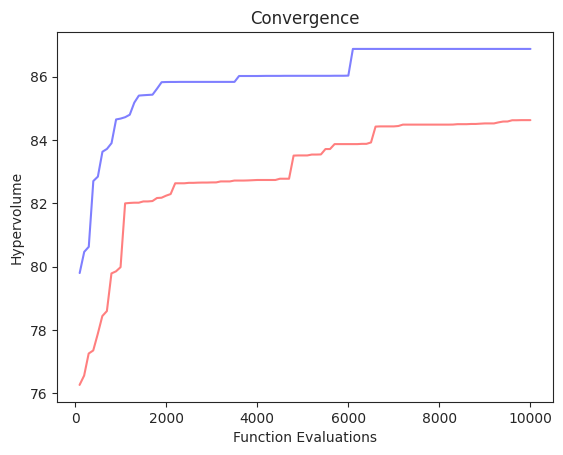

In [125]:
fig, ax = plt.subplots()
plot_convergence([result],ax = ax, color = 'red')
plot_convergence([result1],ax = ax, color = 'blue')

In [6]:
def run_experiment(**kwargs):
    problem = kwargs.get('problem', None)
    n_population = kwargs.get('n_population', 100)
    n_gen = kwargs.get('n_gen', 100)
    sampling = kwargs.get('sampling', None)
    seed = kwargs.get('seed', 42)
    crossover = kwargs.get('crossover', UniformCrossover())
    mutation = kwargs.get('mutation', None)
    max_features = kwargs.get('max_features', 100)
    verbose = kwargs.get('verbose', True)
    algorithm = kwargs.get('algorithm', None)
    
    algorithm = algorithm(pop_size = n_population,
                      sampling = sampling,
                	  crossover = crossover,
                	  mutation = mutation,
                      save_history = True)
    
    result = minimize(problem,  # problem class
                      algorithm,  # algorithm
                      ("n_gen", n_gen), # number of iteration for eval problem class
                      verbose=verbose)
    return result

### Convergence Plot Functions

In [27]:
def get_hv(result, **kwargs):
    n_evals = np.array([e.evaluator.n_eval for e in result.history])
    opt = np.array([e.opt[0].F for e in result.history])
    X_res, F_res = result.opt.get("X", "F")
            
    hist = result.history
    max = 100
    ref_point = np.array([100, -0.0])
    ind = HV(ref_point=ref_point)
            
    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
            
    for algo in hist:
        n_evals.append(algo.evaluator.n_eval)  # store the number of function evaluations
        opt = algo.opt # retrieve the optimum from the algorithm
        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])
        
    metric = HV(ref_point= ref_point, norm_ref_point=False)
    hv = [metric.do(_F) for _F in hist_F]
    return n_evals, hv

def plot_convergence(results, **kwargs):
    color = kwargs.get('color', 'black')
    alpha = kwargs.get('alpha', 0.5)
    label = kwargs.get('label', None)
    ax = kwargs.get('ax', None)
    hvs, n_evals = [], []
    for result in results:
        hv = get_hv(result)
        hvs.extend(hv[1])
        n_evals.extend(hv[0])
    df =  pd.DataFrame({
            "Function Evaluations": n_evals,
            "Hypervolume": hvs})

    sns.lineplot(data=df, x="Function Evaluations", y="Hypervolume", color = color, label=label, alpha = alpha, ax = ax)
    ax.set_title('Convergence')
    #plt.plot(df['n_evals'], df['HV'],  color='black', lw=0.7, label="Avg. CV of Pop", alpha = alpha)
    #plt.scatter(df['n_evals'], df['HV'],  facecolor="none", edgecolor=color, marker="p", alpha = alpha)

### Pareto Front Plot Function

In [26]:
def plot_pareto_front(df, color, marker, label, alpha, ax, **kwargs):
    sns.scatterplot(data = df ,x = 'n_features', y = 'f1_score', color = color,  marker=marker, label=label, alpha = alpha, ax = ax)
    sns.lineplot(data = df ,x = 'n_features', y = 'f1_score', color = color, legend=False, linewidth=1, alpha = alpha, ax = ax)
    ax.legend(loc="upper right")

def plot_multiple_pareto_front(results, **kwargs):
    color = kwargs.get('color', 'black')
    title = kwargs.get('title', 'Mean Pareto Front')
    label = kwargs.get('label', '-')
    alpha = kwargs.get('alpha', 0.7)
    moead = kwargs.get('moead', False)
    ax = kwargs.get('ax', None)
    #plt.figure(figsize=(7, 5))
    F_res = []
    for result in results:
        F_res.extend(list(result.opt.get("F"))) 
    F_res = np.array(F_res)
    unique_keys = np.unique(F_res[:, 0])
    F_res = np.array([[key, F_res[F_res[:, 0] == key, 1].mean()] for key in unique_keys])
    df = pd.DataFrame({'n_features': F_res[:, 0][np.argsort(F_res[:, 0])],
                      'f1_score': F_res[:, 1][np.argsort(F_res[:, 0])]})
    if moead:
        df[['n_features']] = df[['n_features']] * 60
    ax.set_title(title)
    plot_pareto_front(df = df, color = color, marker = 'o', label = label, alpha = alpha, ax = ax)

def plot_best_pareto_front(results, **kwargs):
    color = kwargs.get('color', 'black')
    title = kwargs.get('title', 'Mean Pareto Front')
    label = kwargs.get('label', '-')
    alpha = kwargs.get('alpha', 0.7)
    moead = kwargs.get('moead', False)
    ax = kwargs.get('ax', None)
    #plt.figure(figsize=(7, 5))
    F_res = []
    for result in results:
        F_res.extend(list(result.opt.get("F"))) 
    F_res = find_pareto_frontier(F_res)
    F_res = np.array(F_res)
    unique_keys = np.unique(F_res[:, 0])
    F_res = np.array([[key, F_res[F_res[:, 0] == key, 1].min()] for key in unique_keys])
    df = pd.DataFrame({'n_features': F_res[:, 0][np.argsort(F_res[:, 0])],
                      'f1_score': F_res[:, 1][np.argsort(F_res[:, 0])]})
    ax.set_title(title)
    plot_pareto_front(df = df, color = color, marker = 'o', label = label, alpha = alpha, ax = ax)

def find_pareto_frontier(points):
    unique_points = []
    seen = set()
    for point in points:
        tuple_point = tuple(point)
        if tuple_point not in seen:
            seen.add(tuple_point)
            unique_points.append(point)
    frontier = []
    for p in unique_points:
        is_dominated = False
        for q in unique_points:
            if np.array_equal(q, p):
                continue  # Não comparar o mesmo ponto
            if (np.all(q <= p) and np.any(q < p)):
                is_dominated = True
                break
        if not is_dominated:
            frontier.append(p)
    
    return frontier

### Getting SC's

In [10]:
def getSparseEAWeight(X, y):
    X = np.array(X)
    weights = []
    for i in trange(len(X[0])):
        f_1 = []
        n_tests = 5
        seed = 41
        X_selected = X[:,i]
        for i in range(n_tests):
            seed = seed + 1
            skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True) # Kfolding usado para separar em treino e teste
            clf = CLASSIFIER # treino usando modelo definido
            f_1.append(np.mean(cross_val_score(clf, X_selected.reshape(-1, 1), y, cv=skf, scoring='f1_macro', n_jobs = 10))) # Computar f1
        
        weights.append(round(np.array(f_1).sum()/n_tests, 3))
    return weights

def getRelieff(X, y):
    relieff = ReliefF(n_features_to_select=10, n_neighbors=10, n_jobs=48)  # Ajuste os parâmetros conforme necessário
    pipeline = make_pipeline(
        StandardScaler(),
        relieff)
    pipeline.fit(np.array(X), np.ravel(np.array(y)))
    return pipeline.steps[1][1].feature_importances_

def getRF(X,y):
    clf = RandomForestClassifier(n_estimators=10000, n_jobs=48)
    pipeline = make_pipeline(
            StandardScaler(),
            clf)
    pipeline.fit(X, np.ravel(y))
    return pipeline.steps[1][1].feature_importances_
     

In [11]:
def run_dataset(X, y, n_experiments, n_population, n_gen, max_features, n_process):
    try:
        pool.close()
    except:
        pass
    pool = multiprocessing.Pool(n_process, initializer=_init_evaluator(X,y))
    runner = StarmapParallelization(pool.starmap)
    problem = GeneSelection(X,y, runner)

    sc_rf = getRF(X, y)
    sc_relieff = getRelieff(X, y)
    sc_sparseEA = getSparseEAWeight(X,y)
    
    results_dict = dict({'nsga2': [],
                         'spea2':[],
                         'sparseEA':[],
                         'mofs_rfga': [],
                         'nsga2_weighted': []})
    for i in tqdm(range(n_experiments)):
        
        result = run_experiment(problem = problem,
                   algorithm = NSGA2,
                   n_population = n_population,
                   n_gen = n_gen,
                   sampling = BinaryRandomSampling(max_features = max_features),
                   seed = i,
                   mutation = BitflipMutationLimitedBalanced(),
                   crossover = UniformCrossover(),
                   max_features = max_features)
        results_dict['nsga2'].append(result)
    
        result = run_experiment(problem = problem,
                   algorithm = SPEA2,
                   n_population = n_population,
                   n_gen = n_gen,
                   sampling = BinaryRandomSampling(max_features = max_features),
                   seed = i,
                   mutation = BitflipMutationLimitedBalanced(),
                   crossover = UniformCrossover(),
                   max_features = max_features)
        results_dict['spea2'].append(result)

        result = run_experiment(problem = problem,
                   algorithm = NSGA2,
                   n_population = n_population,
                   n_gen = n_gen,
                   sampling =  SparseEASampling(sc = sc_sparseEA),
                   seed = i,
                   mutation = SparseEAMutation(weights = sc_sparseEA, max_features = max_features),
                   crossover = SparseEACrossover(sc = sc_sparseEA),
                   max_features = max_features)
        results_dict['sparseEA'].append(result)
    
        result = run_experiment(problem = problem,
                   algorithm = NSGA2,
                   n_population = n_population,
                   n_gen = n_gen,
                   sampling = ReliefFSampling(sc = sc_relieff),
                   seed = i,
                   mutation = ReliefFMutation(sc = sc_relieff, max_features = max_features),
                   crossover = ThreeToOneCrossover(sc = sc_relieff),
                   max_features = max_features)
        results_dict['mofs_rfga'].append(result)

        result = run_experiment(problem = problem,
                   algorithm = NSGA2,
                   n_population = n_population,
                   n_gen = n_gen,
                   sampling = BinaryDistributedWeightsSampling(sampling_weights = sc_rf),
                   seed = i,
                   mutation = BitflipMutationLimitedBalanced(weights = sc_rf, max_features = max_features),
                   crossover = UniformCrossover(),
                   max_features = max_features)
        results_dict['nsga2_weighted'].append(result)
        for label in results_dict:
            for res in results_dict[label]:
                res = clean_result(res)
    return results_dict

def clean_result(res):
    for pop in res.history:
        pop.archive = None
        pop.advance = None
        pop.callback = None
        pop.data = None
        pop.mating = None
        pop.display = None
        pop.pop = None
        pop.problem = None
        pop.output = None
        pop.pop_size = None
        pop.problem = None
        pop.repair = None
        pop.result = None
        pop.return_least_infeasible = None
        pop.run = None
        pop.save_history = None
        pop.seed = None
        pop.setup = None
        pop.survival = None
        pop.tell = None
        pop.termination = None
        pop.tournament_type = None
        pop.verbose = None
    return res

def plot_convergence_and_pareto_front(results):
    colors = {'age_moea': 'black',
            'nsga2': 'blue',
            'spea2': 'gray',
            'sparseEA': 'yellow',
            'mofs_rfga': 'purple',
            'nsga2_weighted': 'red'}
    # Cria figura com 2 subplots lado a lado (1 linha, 2 colunas)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    
    for label in results:
        plot_multiple_pareto_front(results[label], color = colors[label], label = label, ax = ax1)
    for label in results:
        plot_convergence(results[label], color = colors[label], label = label, ax = ax2)
    for label in results:
        plot_best_pareto_front(results[label], color = colors[label], label = label, ax = ax3)


In [115]:
X, y = make_classification(random_state=42, n_samples = 100, n_features = 200, n_informative = 20)

pool = multiprocessing.Pool(20, initializer=_init_evaluator(X,y))
runner = StarmapParallelization(pool.starmap)
problem = GeneSelection(X,y, runner)
result = run_experiment(problem = problem,
                   algorithm = NSGA2,
                   n_population = 100,
                   n_gen = 25,
                   sampling = BinaryRandomSampling(max_features = 200),
                   seed = 42,
                   mutation = BitflipMutationLimitedBalanced(max_features = 200),
                   crossover = UniformCrossover(),
                   max_features = 200)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      4 |             - |             -
     2 |      200 |      2 |  0.3333333333 |         ideal
     3 |      300 |      4 |  0.1272727273 |         ideal
     4 |      400 |      3 |  0.3928571429 |         ideal
     5 |      500 |      7 |  0.3333333333 |         ideal
     6 |      600 |      3 |  0.4444444444 |         ideal
     7 |      700 |      6 |  0.1764705882 |         ideal
     8 |      800 |      6 |  0.0480000000 |         ideal
     9 |      900 |      4 |  0.2352941176 |         ideal
    10 |     1000 |      6 |  0.1198268741 |             f
    11 |     1100 |      5 |  0.0843373494 |         ideal
    12 |     1200 |      6 |  0.1875000000 |         ideal
    13 |     1300 |      3 |  0.1111111111 |         ideal
    14 |     1400 |      7 |  0.2000000000 |         ideal
    15 |     1500 |      9 |  0.0272373541 |         ideal
    16 |     1600 |      5 |  0.1111111111 |         ide

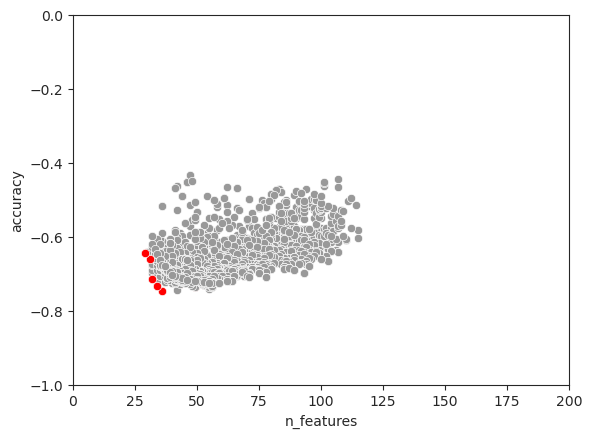

In [116]:
for generation, i in zip(result.history, range(len(result.history))):
    
    acc = []
    n_features = []
    gen = []
    for individual in generation.pop:
        acc.append(individual.F[1])
        n_features.append(individual.F[0])
        gen.append(str(i))
    points = pd.DataFrame({ 'accuracy' : acc,
                            'n_features': n_features,
                            'gen': gen})
    ax = sns.scatterplot(data = points, y = 'accuracy', x = 'n_features', marker = 'o', color = '#999999')#sns.color_palette("flare", 10).as_hex()[i])
    acc = []
    n_features = []
    plt.xlim([0, 200])
    plt.ylim([-1, 0])
    plt.savefig('./gifs/binary_sampling'+str(i)+'_1')
    
    for individual in generation.opt:
        acc.append(individual.F[1])
        n_features.append(individual.F[0])
    red_points = pd.DataFrame({'accuracy' : acc,
                    'n_features' : n_features})
    ax = sns.scatterplot(data = red_points, y = 'accuracy', x = 'n_features',marker = 'o', color='red')
    plt.xlim([0, 200])
    plt.ylim([-1, 0])
    plt.savefig('./gifs/binary_sampling'+str(i)+'_2')

In [100]:
sns.color_palette("flare", 10).as_hex()[0]

'#d0384e'

In [ ]:
import seaborn as sns
from sklearn.datasets import make_classification
import multiprocessing, os
import numpy as np
from pymoo.core.problem import Problem, ElementwiseProblem, StarmapParallelization
#from functions import *

def _init_evaluator(X, y):
    global pid_, X_worker, y_worker
    pid_ = os.getpid()
    X_worker = np.array(X).copy()
    y_worker = np.ravel(y).copy()

try:
    pool.close()
    _pool.close()
except:
    pass
    
n_process = 48

X, y = make_classification(random_state=42, n_samples = 100, n_features = 100, n_informative = 10, n_redundant=10, n_repeated=10)

sns.set_style('ticks')
pool = multiprocessing.Pool(n_process, initializer=_init_evaluator(np.zeros((100,100)),np.zeros(100)))
runner = StarmapParallelization(pool.starmap)
problem = GeneSelection(X = X, y = y, runner=runner)

classifier = DecisionTreeClassifier()

individuals = BinaryPoolSampling(max_features = 100, seed = 12, pool = pool_values).do(problem, n_samples = 100)
x = []
eval = []
for i in individuals:
    x.append(i.X.sum())
    eval.append(np.array(cross_val_score(classifier, X[:,i.X], y, cv=3)).mean())
data = pd.DataFrame({'accuracy' : eval,
                    'n_features' : x})
ax = sns.scatterplot(data = data, y = 'accuracy', x = 'n_features',marker = 'o', color='#999999')

##################################################################################################33

individuals = BinaryDistributedWeightsSampling(max_features = 100, seed = 12).do(problem, n_samples = 100)
x = []
eval = []
for i in individuals:
    x.append(i.X.sum())
    eval.append(np.array(cross_val_score(classifier, X[:,i.X], y, cv=3)).mean())
data = pd.DataFrame({'accuracy' : eval,
                    'n_features' : x})
ax = sns.scatterplot(data = data, y = 'accuracy', x = 'n_features',marker = '^', color='#333333')

ax.legend(['Random Sampling', 'Distributed Random Sampling'], loc='lower right')

##################################################################################################
rf = getRF(X,y)
individuals = BinaryDistributedWeightsSampling(max_features = 100, seed = 12, sampling_weights = rf).do(problem, n_samples = 100)
x = []
eval = []
for i in individuals:
    x.append(i.X.sum())
    eval.append(np.array(cross_val_score(classifier, X[:,i.X], y, cv=3)).mean())
data = pd.DataFrame({'accuracy' : eval,
                    'n_features' : x})
ax = sns.scatterplot(data = data, y = 'accuracy', x = 'n_features',marker = 's', color='red')

ax.legend(['MOO-HFS Sampling', 'Distributed Random Sampling', 'EW-MOFS Sampling'], loc='lower right')
sns.despine()

### P01

In [24]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = np.array(breast_cancer_wisconsin_diagnostic.data.features).astype('float32') 
y = np.ravel(np.array(breast_cancer_wisconsin_diagnostic.data.targets))

print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 569
NF: 30
NC: 2


### P02

In [25]:
satellite = fetch_ucirepo(id=146)

X = np.array(satellite.data.features).astype('float32') 
y = np.ravel(np.array(satellite.data.targets))
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 6435
NF: 36
NC: 6


### P03

In [26]:
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 

X = np.array(optical_recognition_of_handwritten_digits.data.features).astype('float32') 
y = np.ravel(np.array(optical_recognition_of_handwritten_digits.data.targets))
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 5620
NF: 64
NC: 10


### P04

In [27]:
madelon = fetch_openml(data_id = 1485, parser = 'auto')
X = madelon.data
y = madelon.target

print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 2600
NF: 500
NC: 2


### P05

In [28]:
X = pd.read_csv('./Data/UJIIndoorLoc_validationData.csv').iloc[:, :520]
y = pd.read_csv('./Data/UJIIndoorLoc_validationData.csv')['BUILDINGID']
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 1111
NF: 520
NC: 3


### P06

In [29]:
har = fetch_openml(data_id=1478, parser='auto')
X = har.data
y = har.target

print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 10299
NF: 561
NC: 6


### P07

In [30]:
isolet5 = pd.read_csv('./Data/isolet5.data', header=None)
X = np.array(isolet5.iloc[:,:-1])
y = np.ravel(np.array(isolet5.iloc[:,-1]))
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 1559
NF: 617
NC: 26


### P08

In [31]:
# Carregar o dataset "Multiple Features" (ID no OpenML: 554)

mfeat_factors = fetch_openml(data_id=12, parser='auto')
mfeat_fourier = fetch_openml(data_id=14, parser='auto')
mfeat_karhunen = fetch_openml(data_id=16, parser='auto')
mfeat_morphological = fetch_openml(data_id=18, parser='auto')
mfeat_pixel = fetch_openml(data_id=20, parser='auto')
mfeat_zernike = fetch_openml(data_id=22, parser='auto')

fac = np.array(mfeat_factors.data)
fou = np.array(mfeat_fourier.data)
kar = np.array(mfeat_karhunen.data)
mor = np.array(mfeat_morphological.data)
pix = np.array(mfeat_pixel.data)
zer = np.array(mfeat_zernike.data)

# Converter para DataFrame do pandas
X = np.hstack((fac, fou, kar, pix, zer, mor))
y = np.ravel(np.array(mfeat_factors.target))
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 2000
NF: 649
NC: 10


### P09

In [32]:
cnae = fetch_openml(data_id=1468, parser='auto')
X = np.array(cnae.data)
y = np.ravel(np.array(cnae.target))

X.shape, y.shape
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 1080
NF: 856
NC: 9


### P10

In [33]:
qsar_androgen_receptor = pd.read_csv('./Data/qsar_androgen_receptor.csv', sep = ';')

y = np.array(qsar_androgen_receptor['positive'])
X = np.array(qsar_androgen_receptor.drop(['positive'],axis = 1)).astype('float32')
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 1686
NF: 1024
NC: 2


### P11

In [34]:
# Carregar o dataset "Micromass" (ID no OpenML: 1508)
micromass = fetch_openml(data_id=1515, parser='auto')
X = np.array(micromass.data).astype('float32')
y = np.ravel(np.array(micromass.target)).astype('int')

print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 571
NF: 1300
NC: 20


### P12

In [35]:
colon = fetch_openml(data_id=45087, parser='auto')
X = np.array(colon.data)
y = np.ravel(np.array(colon.target))
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 62
NF: 2000
NC: 2


### Cumida

### P13

In [44]:
Liver_GSE14520 = pd.read_csv('Data/Liver_GSE14520_U133A.csv', sep = ',')
X = np.array(Liver_GSE14520.drop(['samples', 'type'],axis = 1)).astype('float32')
y = np.array(Liver_GSE14520['type'])
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 357
NF: 22277
NC: 2


### P14

In [45]:
Leukemia_GSE28497 = pd.read_csv('Data/Leukemia_GSE28497.csv', sep = ',')
X = np.array(Leukemia_GSE28497.drop(['samples', 'type'],axis = 1)).astype('float32')
y = np.array(Leukemia_GSE28497['type'])
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 281
NF: 22283
NC: 7


### P15

In [42]:
Breast_GSE70947 = pd.read_csv('Data/Breast_GSE70947.csv', sep = ',')
X = np.array(Breast_GSE70947.drop(['type', 'samples'], axis = 1))
y = np.array(Breast_GSE70947['type'])

print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))
#data_Breast_GSE70947_norm_results = run_dataset(X = X, y = y, n_experiments = 5, n_population = 100, n_gen = 100, max_features = 100, n_process = 48)

NS: 289
NF: 35981
NC: 2


### P16

In [46]:
Colorectal_GSE44076 = pd.read_csv('Data/Colorectal_GSE44076.csv', sep = ',')
X = np.array(Colorectal_GSE44076.drop(['samples', 'type'],axis = 1)).astype('float32')
y = np.array(Colorectal_GSE44076['type'])
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 194
NF: 49386
NC: 2


### P17

In [48]:
Renal_GSE53757 = pd.read_csv('Data/Renal_GSE53757.csv', sep = ',')
X = np.array(Renal_GSE53757.drop(['samples', 'type'],axis = 1)).astype('float32')
y = np.array(Renal_GSE53757['type'])
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 143
NF: 54675
NC: 2


### P18

In [49]:
Breast_GSE45827 = pd.read_csv('Data/Breast_GSE45827.csv', sep = ',')
X = np.array(Breast_GSE45827.drop(['samples', 'type'],axis = 1)).astype('float32')
y = np.array(Breast_GSE45827['type'])
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 151
NF: 54675
NC: 6


### P19

In [50]:
Colorectal_GSE21510 = pd.read_csv('Data/Colorectal_GSE21510.csv', sep = ',')
X = np.array(Colorectal_GSE21510.drop(['samples', 'type'],axis = 1)).astype('float32')
y = np.array(Colorectal_GSE21510['type'])
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 147
NF: 54675
NC: 3


### P20

In [55]:
Brain_GSE50161 = pd.read_csv('Data/Brain_GSE50161.csv', sep = ',')
X = np.array(Brain_GSE50161.drop(['samples', 'type'],axis = 1))
y = np.array(Brain_GSE50161['type'])
print("NS:", X.shape[0])
print("NF:", X.shape[1])
print("NC:", len(set(y)))

NS: 130
NF: 54675
NC: 5


## Resultados